# GO term and KEGG analysis for featureCounts data
alpha = 0.05, lfcThreshold = 1, altHypothesis = 'greaterAbs'

In [9]:
# loading libraries
library(topGO)
library(KEGGREST)
library(dplyr)
library(clusterProfiler)
library(ggridges)
library(ggplot2)

### I. Clean and prep data frame for analysis
**starting with WARM vs. CONTROL in phase 1 samples (ignoring effects of phase 2)**

In [14]:
# read in the data frame generated from DESeq2
fc_data <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/LFC_FC_sig_p1wc.csv')
head(fc_data)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOC111120752,0.9171026,0.9897897,1.3692762,0.0000000,1.0000000,NA
2,LOC111109452,1.3692365,2.0862336,1.6242781,0.6687485,0.5036559,NA
3,LOC111124802,160.7331187,0.4677914,0.1914082,0.0000000,1.0000000,1
4,LOC111101273,55.0404755,0.4200722,0.2317512,0.0000000,1.0000000,1
5,LOC111101250,77.7947775,-0.6155324,0.2079418,0.0000000,1.0000000,1
6,LOC111101262,188.9039051,0.1706908,0.1825152,0.0000000,1.0000000,1


In [15]:
# selecting only the rows I need for analysis
fc_data2 <- select(fc_data, X, log2FoldChange, padj)

# renaming columns
colnames(fc_data2) <- c('gene', 'lfc', 'padj')

head(fc_data2)

,gene,lfc,padj
,<chr>,<dbl>,<dbl>
1,LOC111120752,0.9897897,NA
2,LOC111109452,2.0862336,NA
3,LOC111124802,0.4677914,1
4,LOC111101273,0.4200722,1
5,LOC111101250,-0.6155324,1
6,LOC111101262,0.1706908,1


need to create a numeric vector for input into GO and KEGG analysis

according to DESeq analysis, we only have 71 genes that fit our criteria above (p-value < 0.05 and |lfc| > 1, but for KEGG we're doing ranked analysis so we need *all* genes in the data set, not just the ones of interest

going right into KEGG analysis and skipping GO for right now - KEGG seems more relavent

### II. clusterProfiler for KEGG analysis
this package works with entrez IDs and currently our data is associated with accession numbers or ensembl IDs - I use [DAVID web interface](https://david.ncifcrf.gov/conversion2.jsp) to convert IDs

In [22]:
# loading in DAVID conversion txt file
david_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/featureCounts analysis/lfc_entrez_convert.txt', sep = '\t')

# renaming columns
colnames(david_df) <- c('gene', 'entrez')

head(david_df)

,gene,entrez
,<chr>,<int>
1,LOC111104814,111104814
2,LOC111104811,111104811
3,LOC111104817,111104817
4,LOC111104816,111104816
5,LOC111104803,111104803
6,LOC111104802,111104802


In [23]:
merge_df <- merge(david_df, fc_data2, by = 'gene', all=TRUE)
head(merge_df)

,gene,entrez,lfc,padj
,<chr>,<int>,<dbl>,<dbl>
1,LOC111099029,111099029,-1.09682937,1
2,LOC111099033,111099033,-2.17061076,NA
3,LOC111099035,111099035,-0.98048246,NA
4,LOC111099036,111099036,0.12372584,NA
5,LOC111099040,111099040,-0.07325383,NA
6,LOC111099041,111099041,1.29220550,NA


In [45]:
# omitting any genes with NA for padj
df <- na.omit(merge_df)
dim(df)

[1] 4578    4

In [46]:
# only selecting the entrezID and lfc columns
kegg_df <- select(df, entrez, lfc)
head(kegg_df)

,entrez,lfc
,<int>,<dbl>
1,111099029,-1.0968294
10,111099050,-0.3515202
14,111099062,0.3208163
16,111099067,-0.2551416
17,111099073,-0.1178653
18,111099079,0.2547889


need to create kegg object for input into clusterProfiler for KEGG analysis

In [47]:
# creating numeric vector with entrez ID and associated log2foldchange
kegg_gene_list <- kegg_df$lfc
names(kegg_gene_list) <- kegg_df$entrez

# omit any NA values
kegg_gene_list <- na.omit(kegg_gene_list)

# sort list in descending order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

# checking that things look okay
head(kegg_gene_list)
class(kegg_gene_list) # numeric vector

111102814 111113225 111134419 111109964 111129379 111134796 
 4.688483  4.669447  4.509550  4.502378  4.410529  4.409370

[1] "numeric"

now doing the actual KEGG analysis [documentation](https://www.rdocumentation.org/packages/clusterProfiler/versions/3.0.4/topics/gseKEGG)

In [85]:
kegg_organism = 'cvn'
kk2 <- gseKEGG(geneList = kegg_gene_list,
               organism = kegg_organism,
               #minGSSize = 1,
               #maxGSSize = 800,
               pvalueCutoff = 1,
               pAdjustMethod = 'BH', #Benjamini-Hockberg FDR
               scoreType = 'std', # standard - only change for one-tailed tests
               keyType = 'kegg')

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



In [83]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df,10)

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
cvn00240,cvn00240,Pyrimidine metabolism,15,0.7309323,1.566012,0.005754952,0.4258664,0.4179913,755,"tags=40%, list=16%, signal=34%",111103017/111135848/111124500/111134405/111127104/111135526
cvn03460,cvn03460,Fanconi anemia pathway,18,0.6917099,1.512215,0.014795411,0.5474302,0.5373070,572,"tags=39%, list=12%, signal=34%",111129379/111128124/111130645/111131048/111121059/111108030/111129910
cvn03250,cvn03250,Viral life cycle,18,0.6599688,1.442823,0.032044199,0.5509824,0.5407936,787,"tags=50%, list=17%, signal=42%",111124701/111124696/111129825/111111579/111108190/111128997/111135084/111106750/111130886
cvn04146,cvn04146,Peroxisome,33,0.5862661,1.386915,0.037228542,0.5509824,0.5407936,935,"tags=33%, list=20%, signal=27%",111107393/111113990/111115744/111107112/111115745/111134248/111131127/111101232/111131586/111135201/111106696
cvn04814,cvn04814,Motor proteins,63,0.5365122,1.324912,0.034034034,0.5509824,0.5407936,1122,"tags=32%, list=25%, signal=24%",111134768/111107338/111112439/111115784/111129526/111107250/111127380/111134843/111119946/111120500/111129376/111125250/111131555/111129377/111126828/111124938/111125905/111120967/111130343/111131749
cvn00380,cvn00380,Tryptophan metabolism,15,0.6175973,1.323193,0.124153499,0.7344610,0.7208793,1037,"tags=47%, list=23%, signal=36%",111127901/111103451/111133558/111134248/111130627/111108303/111103498
cvn03015,cvn03015,mRNA surveillance pathway,32,0.5461436,1.290206,0.099276112,0.7344610,0.7208793,1606,"tags=66%, list=35%, signal=43%",111129219/111100273/111134286/111122880/111138352/111108043/111130886/111118849/111136672/111129063/111135694/111136311/111128721/111134707/111103429/111108106/111118848/111122970/111128988/111135433/111130150
cvn00640,cvn00640,Propanoate metabolism,18,0.5878150,1.285080,0.139226519,0.7344610,0.7208793,818,"tags=28%, list=18%, signal=23%",111105925/111130103/111107112/111099995/111100523
cvn00500,cvn00500,Starch and sucrose metabolism,10,0.6493694,1.280869,0.156327543,0.7344610,0.7208793,947,"tags=50%, list=21%, signal=40%",111125157/111135290/111129461/111120703/111137764


Picking joint bandwidth of 0.411



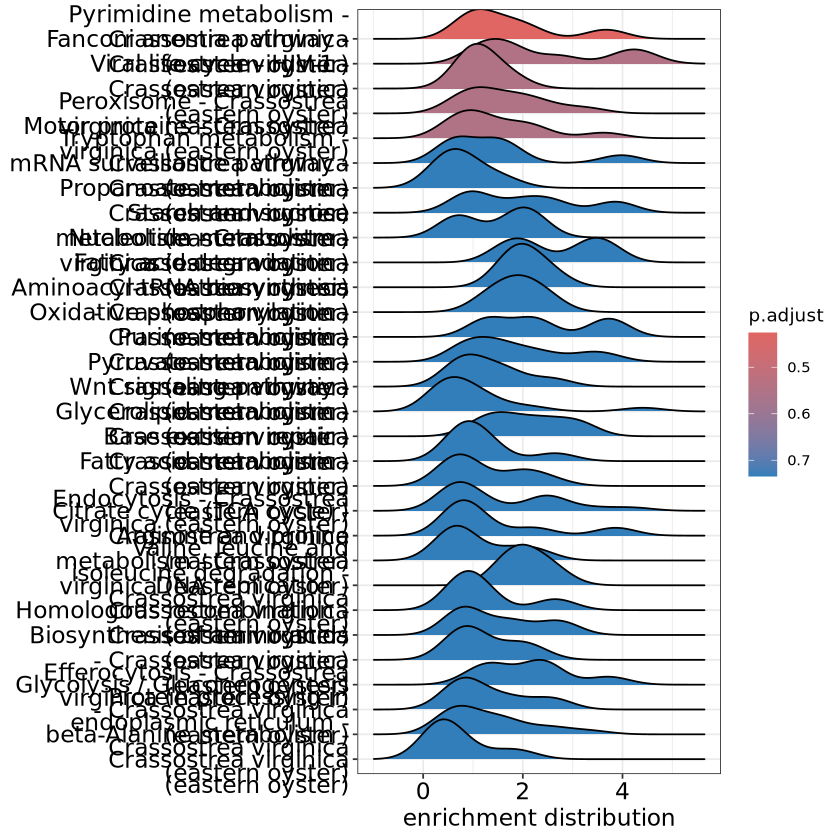

In [81]:
ridgeplot(kk2) + labs(x='enrichment distribution')

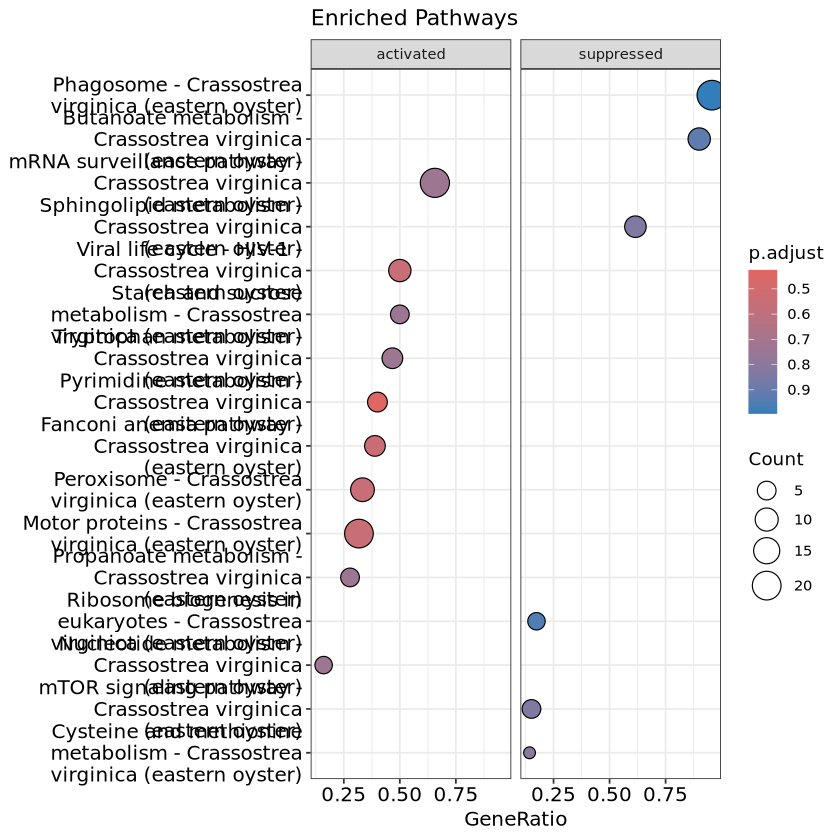

In [79]:
dotplot(kk2, showCategory = 10, title = 'Enriched Pathways', split = '.sign') + facet_grid(.~.sign)

Warning message in cnetplot.enrichResult(x, ...):
“Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


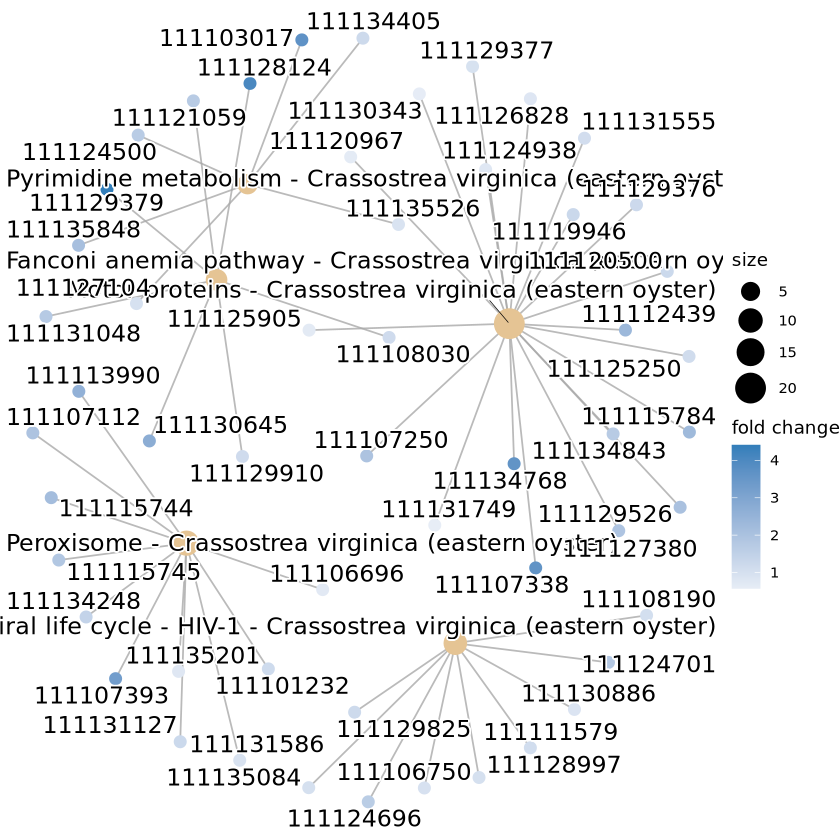

In [84]:
cnetplot(kk2, categorySize="pvalue", foldChange=kegg_gene_list)

## now doing the same thing but with data from **lfcShrink()**

In [86]:
lfc_shrink <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/lfcshrink_data.csv')
head(lfc_shrink)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOC111120752,0.9171026,0.5117345,0.7219483,0.7228562,0.469768260,NA
2,LOC111109452,1.3692365,1.0072548,0.7205748,1.2844067,0.198999706,NA
3,LOC111124802,160.7331187,0.4591660,0.1879969,2.4439457,0.014527611,0.12496234
4,LOC111101273,55.0404755,0.4055670,0.2258263,1.8125996,0.069893607,0.35139252
5,LOC111101250,77.7947775,-0.6027753,0.2031945,-2.9601192,0.003075201,0.03921957
6,LOC111101262,188.9039051,0.1674635,0.1795188,0.9352140,0.349678001,0.75717245


In [87]:
# selecting only the rows I need for analysis
lfc_shrink2 <- select(lfc_shrink, X, log2FoldChange, padj)

# renaming columns
colnames(lfc_shrink2) <- c('gene', 'lfc', 'padj')

head(lfc_shrink2)

,gene,lfc,padj
,<chr>,<dbl>,<dbl>
1,LOC111120752,0.5117345,NA
2,LOC111109452,1.0072548,NA
3,LOC111124802,0.4591660,0.12496234
4,LOC111101273,0.4055670,0.35139252
5,LOC111101250,-0.6027753,0.03921957
6,LOC111101262,0.1674635,0.75717245


In [88]:
# loading in DAVID conversion txt file
david_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/featureCounts analysis/lfc_shrink_conert.txt', sep = '\t')

# renaming columns
colnames(david_df) <- c('gene', 'entrez')

head(david_df)

,gene,entrez
,<chr>,<int>
1,LOC111108397,111108397
2,LOC111107066,111107066
3,LOC111134686,111134686
4,LOC111107067,111107067
5,LOC111133354,111133354
6,LOC111134688,111134688


In [89]:
merge_df <- merge(david_df, lfc_shrink2, by = 'gene', all=TRUE)
head(merge_df)

,gene,entrez,lfc,padj
,<chr>,<int>,<dbl>,<dbl>
1,LOC111099029,111099029,-0.98190256,0.2029212
2,LOC111099033,NA,-0.26167451,NA
3,LOC111099035,111099035,-0.81617523,0.6450328
4,LOC111099036,111099036,0.09423129,0.9560376
5,LOC111099040,NA,-0.05640949,NA
6,LOC111099041,NA,0.92964584,NA


In [90]:
# omitting any genes with NA for padj
df <- na.omit(merge_df)
dim(df)

[1] 7910    4

In [91]:
# only selecting the entrezID and lfc columns
kegg_df <- select(df, entrez, lfc)
head(kegg_df)

,entrez,lfc
,<int>,<dbl>
1,111099029,-0.98190256
3,111099035,-0.81617523
4,111099036,0.09423129
9,111099047,-0.08462497
10,111099050,-0.33336425
14,111099062,0.26982113


need to create kegg object for input into clusterProfiler for KEGG analysis

In [92]:
# creating numeric vector with entrez ID and associated log2foldchange
kegg_gene_list <- kegg_df$lfc
names(kegg_gene_list) <- kegg_df$entrez

# omit any NA values
kegg_gene_list <- na.omit(kegg_gene_list)

# sort list in descending order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

# checking that things look okay
head(kegg_gene_list)
class(kegg_gene_list) # numeric vector

111102814 111134796 111120187 111134419 111109964 111113225 
 3.788823  3.683084  3.652089  3.507806  3.440026  3.437061

[1] "numeric"

### KEGG analysis with **LFC SHRINK**
now doing the actual KEGG analysis [documentation](https://www.rdocumentation.org/packages/clusterProfiler/versions/3.0.4/topics/gseKEGG)

In [93]:
kegg_organism = 'cvn'
kk2 <- gseKEGG(geneList = kegg_gene_list,
               organism = kegg_organism,
               #minGSSize = 1,
               #maxGSSize = 800,
               pvalueCutoff = 1,
               pAdjustMethod = 'BH', #Benjamini-Hockberg FDR
               scoreType = 'std', # standard - only change for one-tailed tests
               keyType = 'kegg')

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



In [94]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df,10)

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
cvn00511,cvn00511,Other glycan degradation,25,0.6465196,1.687406,0.002391591,0.1183838,0.1095097,1421,"tags=40%, list=18%, signal=33%",111106921/111106925/111106928/111119851/111119435/111120040/111113388/111106926/111119431/111106930
cvn01040,cvn01040,Biosynthesis of unsaturated fatty acids,12,0.7508157,1.679905,0.002130023,0.1183838,0.1095097,1036,"tags=50%, list=13%, signal=44%",111113990/111115744/111107112/111115745/111119293/111124908
cvn03250,cvn03250,Viral life cycle,24,0.6165954,1.598400,0.012591681,0.2077627,0.1921888,1652,"tags=50%, list=21%, signal=40%",111124701/111124696/111129825/111111579/111108190/111135084/111128997/111106750/111123417/111130886/111104027/111135329
cvn03460,cvn03460,Fanconi anemia pathway,29,0.5869636,1.575104,0.011292878,0.2077627,0.1921888,1956,"tags=52%, list=25%, signal=39%",111129379/111128124/111130645/111121059/111131048/111129910/111108030/111102874/111119126/111134136/111138268/111128959/111108150/111120979/111131667
cvn00071,cvn00071,Fatty acid degradation,32,0.5673087,1.553855,0.008821715,0.2077627,0.1921888,1869,"tags=44%, list=24%, signal=34%",111113990/111115744/111107112/111115745/111103451/111112920/111115614/111135553/111121380/111117093/111103498/111129333/111107779/111134458
cvn04814,cvn04814,Motor proteins,78,0.4896956,1.505517,0.008187942,0.2077627,0.1921888,1610,"tags=28%, list=20%, signal=23%",111134768/111107338/111112439/111115784/111129526/111107250/111127380/111134843/111119946/111120500/111129376/111130940/111125250/111131555/111129377/111115167/111126828/111124938/111125905/111120967/111130343/111131749
cvn00592,cvn00592,alpha-Linolenic acid metabolism,10,0.7336287,1.573023,0.015664044,0.2215343,0.2049281,1036,"tags=50%, list=13%, signal=44%",111113990/111115744/111107112/111115745/111124908
cvn04080,cvn04080,Neuroactive ligand-receptor interaction,14,0.6832466,1.587904,0.018247241,0.2258096,0.2088829,1221,"tags=36%, list=15%, signal=30%",111131195/111134720/111119377/111115795/111124637
cvn00380,cvn00380,Tryptophan metabolism,20,0.6175232,1.538210,0.023115120,0.2542663,0.2352065,1507,"tags=50%, list=19%, signal=41%",111127901/111103451/111134248/111133558/111112920/111115614/111121380/111130627/111108303/111103498


interesting because we now we're seeing statistically significant pathways (q-value below 0.2)

Picking joint bandwidth of 0.268



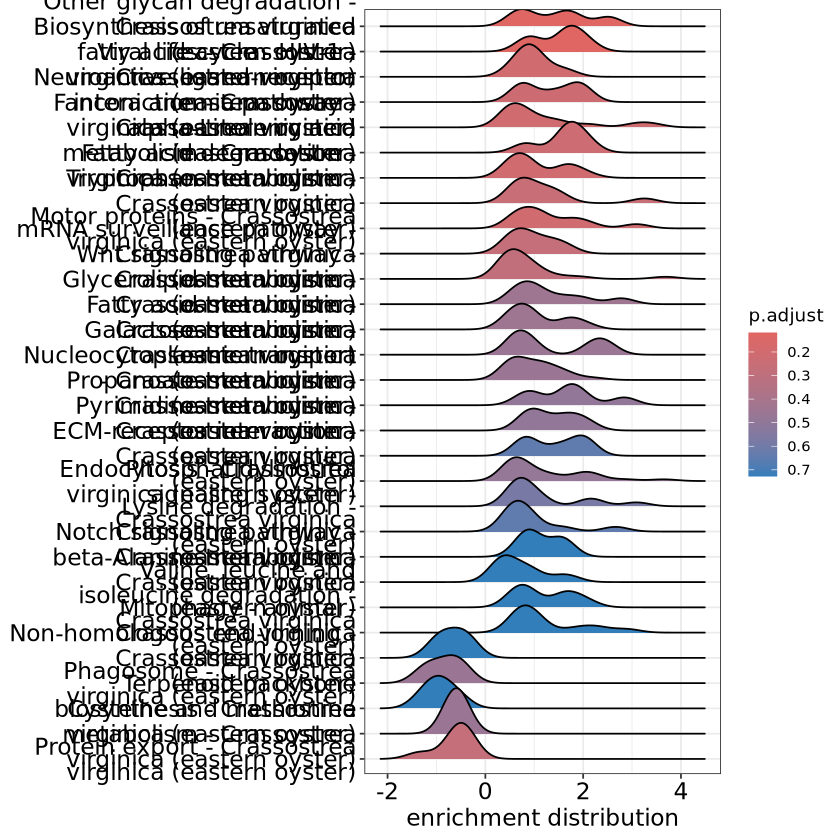

In [95]:
ridgeplot(kk2) + labs(x='enrichment distribution')

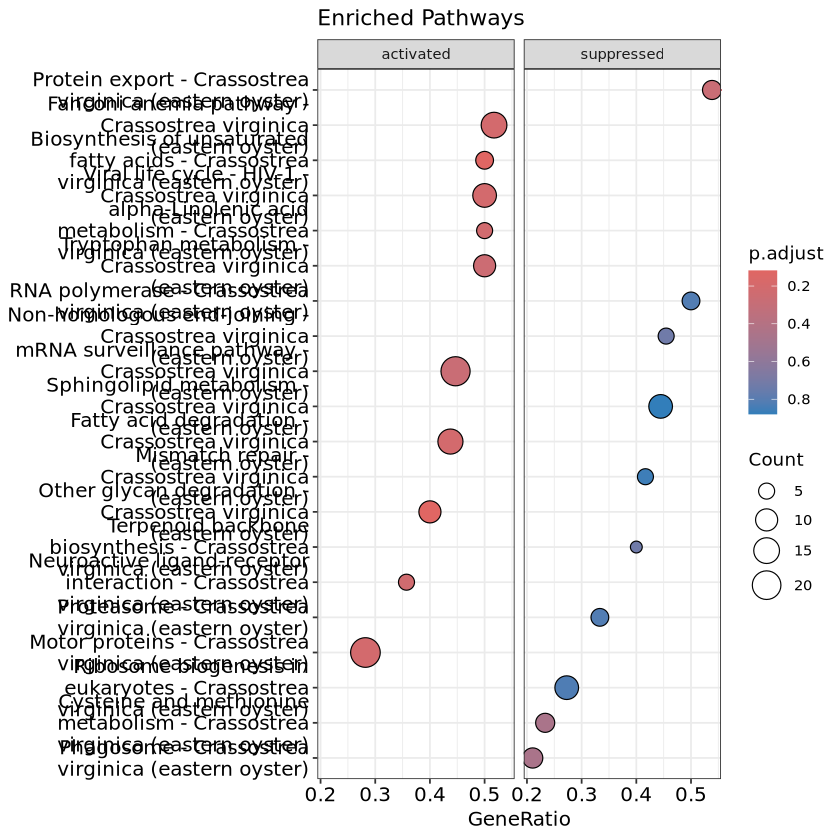

In [96]:
dotplot(kk2, showCategory = 10, title = 'Enriched Pathways', split = '.sign') + facet_grid(.~.sign)

Warning message in cnetplot.enrichResult(x, ...):
“Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


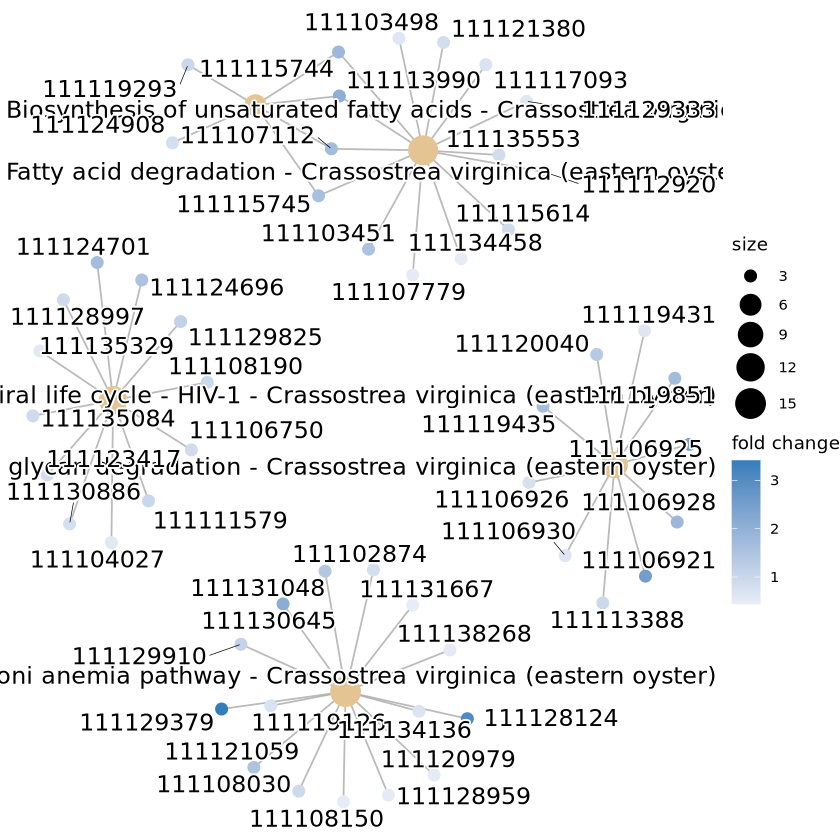

In [97]:
cnetplot(kk2, categorySize="pvalue", foldChange=kegg_gene_list)